# __Step 2.5: Make predictions__

The best model is Word2Vec:
- Because the performance is all very similar, for interpretability purpose, choose to focus on the Word2Vec-based model with ` [min_count, window, n_gram] = [20, 8, 3]`. 
- This way there is a smaller set of eature (because min_count is high) that include tri-grams (so 3 word combinations that help with interpretation).

Goal
- Make predictions of the entire corupus


## ___Set up___

### Module import

In [1]:
import json, tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import metrics
from pathlib import Path
import script_2_3_text_classify_w2v as script23

### Key variables

In [2]:
# Reproducibility
seed = 20220609

# Setting paths
work_dir   = Path.home() / "projects/plant_sci_hist/2_text_classify"

os.chdir(work_dir)

# Training data for interpretation purpose
corpus_train = work_dir / "corpus_train.json"

###
# subfolders for different components of this subproject (2_text_classify)
dir_22 = work_dir / "2_2_model_tf_tfidf"
dir_23 = work_dir / "2_3_model_w2v"
dir_24 = work_dir / "2_4_model_bert"
dir_25 = work_dir / '2_5_predict_pubmed'

###
# The columns to focus on
target_col = 'txt'

###
# w2v model and related files
# Trainded Word2Vec model, tokenizer, and vocab for getting embeddings
w2v_name   = dir_23 / f"model_cln_w2v_20-8-3"
tok_name   = dir_23 / f"model_cln_w2v_token_20-8-3"
vocab_name = dir_23 / f"model_cln_w2v_vocab_20-8-3"

# Getting ngrams
ngram = 3
min_count = 20

# DNN checkpoint path
cp_filepath = dir_23 / f"model_cln_w2v_20-8-3_dnn"

###
# Corpus to make predictions for
corpus_dir  = Path.home() / "projects/plant_sci_hist/1_obtaining_corpus"
corpus_file = corpus_dir / "pubmed_qualified.tsv"

# Output the positive predictions
# The Unnamed: 0 column contains the indices of docs in pubmed_qualified.tsv
corpus_df_pos_file = dir_25 / "corpus_plant_421658.tsv.gz"

### Create dir and move files

In [3]:
dir_22.mkdir(exist_ok=True)
dir_23.mkdir(exist_ok=True)
dir_24.mkdir(exist_ok=True)
dir_25.mkdir(exist_ok=True)


In [4]:
!mv *_tf* {str(dir_22)}
!mv *w2v* {str(dir_23)}
!mv *bert* {str(dir_24)}
!mv model_cln_ngrams* {str(dir_23)} 
!mv corpus_*_pred {str(dir_23)}

mv: cannot move '2_2_model_tf_tfidf' to a subdirectory of itself, '/home/shius/projects/plant_sci_hist/2_text_classify/2_2_model_tf_tfidf/2_2_model_tf_tfidf'
mv: cannot move '2_3_model_w2v' to a subdirectory of itself, '/home/shius/projects/plant_sci_hist/2_text_classify/2_3_model_w2v/2_3_model_w2v'
mv: cannot move '2_4_model_bert' to a subdirectory of itself, '/home/shius/projects/plant_sci_hist/2_text_classify/2_4_model_bert/2_4_model_bert'
mv: cannot stat 'model_cln_ngrams*': No such file or directory
mv: cannot stat 'corpus_*_pred': No such file or directory


## ___Load models and other objects___

### Load w2v model, tokenizer, and vocab

Need:
- W2V model
- Tokenizer and vocab
- Trained DNN model

In [5]:
# Load word2vec model
with open(w2v_name, "rb") as f:
  model_w2v = pickle.load(f)
model_w2v

In [6]:
# Load tokenzier and vocab
with open(tok_name, "rb") as f:
  tokenizer = pickle.load(f)

with open(vocab_name, "rb") as f:
  vocab = pickle.load(f)

### Get training/testing data

In [7]:
# Not needed...
with corpus_train.open("r+") as f:
  corpus_combo_json = json.load(f)

## ___Make predictions on the whole dataset___

### Read corpus that needs to be predicted

In [8]:
corpus_df_raw = pd.read_csv(corpus_file, delimiter='\t')

In [9]:
corpus_df_raw.shape

(1497511, 6)

In [10]:
# Drop duplicated rows
corpus_df = corpus_df_raw[corpus_df_raw.duplicated() == False]

# Rid of all records with NAs
corpus_df = corpus_df.dropna(axis=0)

# Create a new column 'txt' which is concatenated between 'Title' and 'Abstract'
corpus_df['txt'] = corpus_df['Title'] + " " + corpus_df['Abstract']
corpus_df.shape

(1385417, 7)

In [11]:
# Remove corrections and erratum
corpus_df_titles     = corpus_df['Title']
#corpus_df_titles_idx = corpus_df_titles.index
corpus_df_titles_val = corpus_df_titles.values

# Check for title with issues
remove_tokens = ["correction to:", "correction:",  
                 "erratum", "erratum:",
                 "withdrawn", "withdrawn:"]

reg_article_flags = [] # a list of true (should remain) or false (remove)
count_corrections = 0
for title in corpus_df_titles_val:
  reg_article_flag = 1
  title_lower = title.lower()
  for remove_token in remove_tokens:
    if title_lower.find(remove_token) != -1:
      # Only remove this if 
      title_tokens = title_lower.split(" ")
      if remove_token == title_tokens[0] or \
         (len(title_tokens) > 1 and remove_token == title_tokens[1]):
        #print(title)
        reg_article_flag = 0
        count_corrections +=1
        break
  reg_article_flags.append(reg_article_flag)

print("Correction/erratum/withdrawn:", count_corrections)

Correction/erratum/withdrawn: 699


In [12]:
corpus_df["reg_article"] = reg_article_flags
(corpus_df["reg_article"] == 0).value_counts()

False    1384718
True         699
Name: reg_article, dtype: int64

In [13]:
corpus_df = corpus_df[corpus_df["reg_article"] == 1]
corpus_df.shape

(1384718, 8)

In [14]:
corpus_df.head(3)

,PMID,Date,Journal,Title,Abstract,QualifiedName,txt,reg_article
0,36,1975-11-01,The British journal of nutrition,The effects of processing of barley-based supp...,1. In one experiment the effect on rumen pH of...,barley,The effects of processing of barley-based supp...,1
1,52,1975-12-02,Biochemistry,Evidence of the involvement of a 50S ribosomal...,The functional role of the Bacillus stearother...,rose,Evidence of the involvement of a 50S ribosomal...,1
2,60,1975-12-11,Biochimica et biophysica acta,The reaction between the superoxide anion radi...,1. The superoxide anion radical (O2-) reacts w...,tuna,The reaction between the superoxide anion radi...,1


In [15]:
corpus_df['txt'][0][:100]

'The effects of processing of barley-based supplements on rumen pH, rate of digestion of voluntary in'

### Get word embeddings, w2v feature matrix using corpus

In [16]:
# Specify the input corpus
X = corpus_df[target_col]

# Get ngrams: 
# ##### This is not necessary #####
#X_ngrams = script23.get_ngram(X, ngram, min_count, "train", work_dir=work_dir)

In [17]:
# Get embeddings: ~4 min
embeddings, X_w2v = script23.get_embeddings(X, model_w2v, tokenizer, vocab)

In [18]:
embeddings.shape, X_w2v.shape

((398412, 300), (1384718, 500))

In [19]:
X_w2v[0][:20]

array([    1,     1,     1,   856,     1,   631,    65,     1,     1,
       22713,   493,    43,     1,  3786,     1,  8018,  1214,     1,
        4962,  1222], dtype=int32)

### Load model

In [20]:
model_emb = tf.keras.models.load_model(cp_filepath)

2022-07-07 12:42:44.032124: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-07-07 12:42:44.237712: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-07-07 12:42:44.238684: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-07-07 12:42:44.245272: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate


### Make predictions 

In [21]:
# This takes a long time so save the prediction and prediction prob to a file
# ~52 min
y_pred_prob   = model_emb.predict(X_w2v)
dic_y_mapping = {n:label for n,label in enumerate(np.unique([0,1]))}
y_pred        = [dic_y_mapping[np.argmax(pred)] for pred in y_pred_prob]

2022-07-07 12:43:08.746335: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-07-07 12:43:10.399660: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8201


In [22]:
len(y_pred)

1384718

In [23]:
corpus_df["y_prob"] = y_pred_prob[:,1]
corpus_df["y_pred"] = y_pred
corpus_df.shape

(1384718, 10)

In [24]:
corpus_df['y_pred'].value_counts()

0    963060
1    421658
Name: y_pred, dtype: int64

In [25]:
#Save prediction file
corpus_df_file = dir_25/f"pubmed_qual_{corpus_df.shape[0]}_w2v_pred_prob.tsv.gz"
corpus_df.to_csv(corpus_df_file, sep='\t', compression='gzip')

In [26]:
### Consolidate positive predictions into a compressed dataframe
corpus_df[corpus_df['y_pred'] == 1].to_csv(corpus_df_pos_file, sep='\t', 
                                                            compression='gzip')

### Plot probability distribution

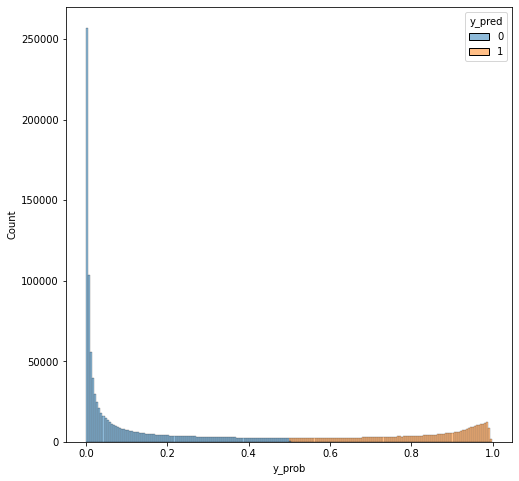

In [27]:
plt.figure(figsize=(8,8))
sns.histplot(data=corpus_df, x="y_prob", hue="y_pred", bins=200)
plt.savefig(dir_25 / 'figure_pubmed_qual_1384718_w2v_pred_prob.pdf')

## ___Check article recovery from other plant journals___

### Select journals and get tpr

- Plant science journals with >2,000 retrieved pubmed records were used for training.
- There are many other plant science journals not covered, particularly those not in molecular plant science, include:
  - Current opinion in plant biology,1806
  - Trends in plant science,1723
  - Functional plant biology : FPB,1717
  - Molecular plant pathology,1573
  - Molecular plant,1141
  - Journal of integrative plant biology,1092
  - Journal of plant research,1032
  - Physiology and molecular biology of plants : an international journal of functional plant biology,830
  - Nature plants,538
  - The plant pathology journal,443
  - Annual review of plant biology,417
  - The plant genome,321

In [28]:
# positive journals not used for training
j_positive_nt = [
  'Current opinion in plant biology',
  'Trends in plant science',
  'Functional plant biology : FPB',
  'Molecular plant pathology',
  'Molecular plant',
  'Journal of integrative plant biology',
  'Journal of plant research',
  'Physiology and molecular biology of plants : an international journal of '+\
    'functional plant biology',
  'Nature plants',
  'The plant pathology journal',
  'Annual review of plant biology',
  'The plant genome']

In [29]:
corpus_df.head(2)

,PMID,Date,Journal,Title,Abstract,QualifiedName,txt,reg_article,y_prob,y_pred
0,36,1975-11-01,The British journal of nutrition,The effects of processing of barley-based supp...,1. In one experiment the effect on rumen pH of...,barley,The effects of processing of barley-based supp...,1,0.162140,0
1,52,1975-12-02,Biochemistry,Evidence of the involvement of a 50S ribosomal...,The functional role of the Bacillus stearother...,rose,Evidence of the involvement of a 50S ribosomal...,1,0.286834,0


In [30]:
def get_tpr(corpus_df, j_to_check, ptype):
  '''Plot prediciton probabilities of each journal
  Args
    df: dataframe with journal names, predictions
    journal: name of journal in pubmed format
    ptype: positive journal type, used for training or not
  Outputs:
    pdf: prediction probability histogram colored based on predicted classes
  '''
  # Count the predictions
  j_to_check_list = []
  for i in j_to_check:
    j_df    = corpus_df[corpus_df['Journal'] == i]     # entries of a journal
    i_count = j_df['y_pred'].value_counts()            # counts of y_pred, series
    j_to_check_list.append(i_count)

  print("Put the series into dataframe")
  j_to_check_df = pd.concat(j_to_check_list, axis=1)
  j_to_check_df.columns = j_to_check
  j_to_check_df = j_to_check_df.transpose()
  print(j_to_check_df.head(2))
  print(j_to_check_df[1].shape[0])

  print("Add tpr column")
  tpr = []
  for i in range(j_to_check_df[1].shape[0]):
    tp = j_to_check_df[1].iloc[i]
    fn = j_to_check_df[0].iloc[i]
    tpr.append(tp/(tp+fn))
  j_to_check_df['tpr'] = tpr

  print("Draw and save bar plot")
  sns.barplot(data=j_to_check_df, x='tpr', y=j_to_check_df.index)

  # Prevent trucated text
  # https://stackoverflow.com/questions/45239261/matplotlib-savefig-text-chopped-off
  plt.savefig(
    dir_25 / f'figure_pubmed_w2v_pred_prob_{ptype}_journal_check_fdr.pdf',
    bbox_inches = "tight")

  return j_to_check_df

Put the series into dataframe
                                     1    0
Current opinion in plant biology  1636  170
Trends in plant science           1450  273
12
Add tpr column
Draw and save bar plot


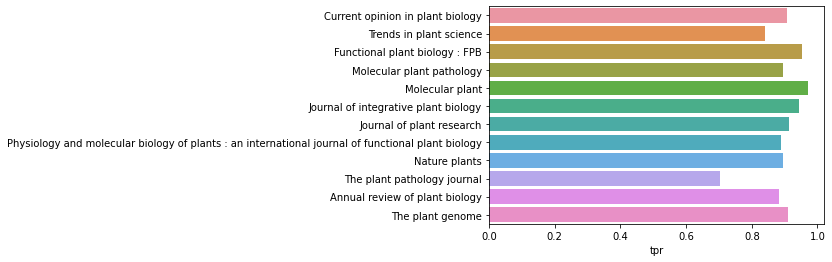

In [31]:
j_positive_nt_df = get_tpr(corpus_df, j_positive_nt, "not-training")

In [32]:
def plot_pdf(df, df_tpr, journal, ptype):
  '''Plot prediciton probabilities of each journal
  Args
    df: dataframe with citations as rows, with columns containing journal names,
      predictions, prediction probabilities, among others
    df_tpr: dataframe with journals as index and a column with tpr values
    journal: name of journal in pubmed format
    ptype: positive journal type, used for training or not
  Outputs:
    pdf: prediction probability histogram colored based on predicted classes
  '''
  df_j   = df[df['Journal'] == journal]
  j_name = "-".join(journal.split(":")[0].strip().split(" "))
  tpr    = round(df_tpr['tpr'].loc[journal], 2) 

  plt.figure(figsize=(4,4))
  sns.histplot(data=df_j, x="y_prob", hue="y_pred", bins=100)
  plt.title(j_name)
  plt.text(0.1, 20, "tpr=" + str(tpr))
  plt.savefig(dir_25 / f'figure_pubmed_w2v_pred_prob_{ptype}_{j_name}.pdf')

In [33]:
for journal in j_positive_more:
  plot_pdf(corpus_df, j_positive_nt_df, journal, "not-training")

NameError: name 'j_positive_more' is not defined

### Also check the positive journals used for training for comparison

In [ ]:
# positive journal used for training
j_pos_t = ['Plant physiology', 'Frontiers in plant science', 'Planta',
             'The Plant journal : for cell and molecular biology', 
             'Journal of experimental botany', 'Plant molecular biology',
             'The New phytologist', 'The Plant cell', 'Phytochemistry',
             'Plant &amp; cell physiology', 'American journal of botany',
             'Annals of botany', 'BMC plant biology', 'Tree physiology',
             'Molecular plant-microbe interactions : MPMI',
             'Plant biology (Stuttgart, Germany)', 
             'Plant biotechnology journal']

In [ ]:
j_positive_t_df = get_tpr(corpus_df, j_pos_t, "not-training")

In [ ]:
for journal in j_pos_t:
  plot_pdf(corpus_df, j_positive_t_df, journal, "training")

### Look into Nature Plants

In [ ]:
corpus_df_nat_pln = corpus_df[corpus_df["Journal"] == "Nature plants"]
corpus_df_nat_pln.shape

In [ ]:
corpus_df_nat_pln_file = dir_25 / 'corpus_df_nat_pln.tsv'
corpus_df_nat_pln.to_csv(corpus_df_nat_pln_file, sep='\t')

### Look into Plant Genome



In [ ]:
corpus_df_pln_genome = corpus_df[corpus_df["Journal"] == "The plant genome"]
corpus_df_pln_genome_file = dir_25 / 'corpus_df_pln_genome.tsv'
corpus_df_pln_genome.to_csv(corpus_df_pln_genome_file, sep='\t')

### Look into Phytochemistry

In [ ]:
corpus_df_phytochem = corpus_df[corpus_df["Journal"] == "Phytochemistry"]
corpus_df_phytochem_file = dir_25 / 'corpus_df_phytochem.tsv'
corpus_df_phytochem.to_csv(corpus_df_phytochem_file, sep='\t')

### Check specific feature

In [ ]:
corpus_df.head(2)

In [ ]:
def check_feat(df, feat):
  df_txt = df['txt']
  feat_found = []
  for txt in tqdm.tqdm(df_txt):
    if feat in txt.lower():
      feat_found.append(1)
    else:
      feat_found.append(0)

  return feat_found



In [ ]:
feat = "phytologist"
feat_found_phytologist = check_feat(corpus_df, feat)

In [ ]:
feat = "university"
feat_found_phytologist = check_feat(corpus_df, feat)

## ___Get number of articles per journal___

### Load predicted plant science citations

In [4]:
plant_sci_file = dir_25 / "corpus_plant_421658.tsv.gz"
plant_sci_df   = pd.read_csv(plant_sci_file, sep="\t", compression="gzip")
plant_sci_df.shape

(421658, 11)

In [10]:
journal_plant_cit_count = pd.DataFrame(plant_sci_df["Journal"].value_counts())
type(journal_plant_cit_count), journal_plant_cit_count.shape

(pandas.core.frame.DataFrame, (3538, 1))

In [11]:
journal_plant_cit_count.head(2)

,Journal
Plant physiology,20584
PloS one,11360


In [14]:
journal_plant_cit_count.to_csv(dir_25 / "table2_5_journal_plant_cit_count.tsv",
                               sep='\t')